In [0]:
import numpy as np
import os 
import tensorflow as tf 
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

In [0]:
def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath

In [0]:
def load_images(directory='', size=(64,64)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0
    
    imagePaths = list(list_images(directory))
    
    for path in imagePaths:
        
        if not('OSX' in path):
        
          path = path.replace('\\','/')

          image = cv2.imread(path) #Reading the image with OpenCV
          image = cv2.resize(image,size) #Resizing the image, in case some are not of the same size

          images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return images

In [0]:
images = load_images(directory='./animeData')

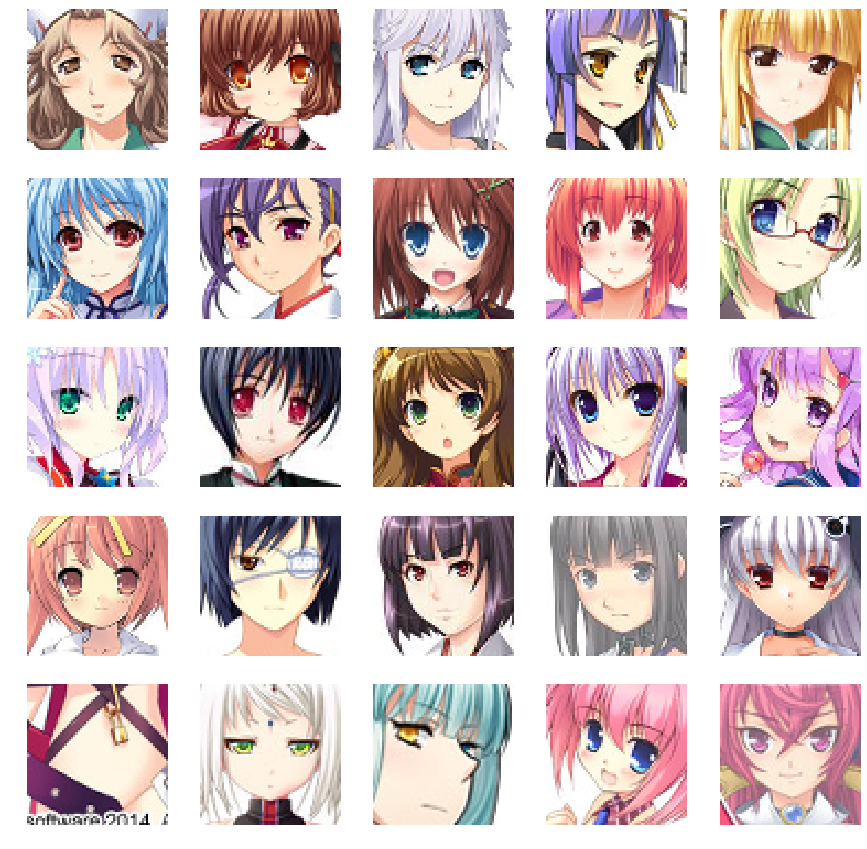

In [27]:
_,ax = plt.subplots(5,5, figsize = (15,15)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

In [0]:
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)
        
        self.noise_size = 100

        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
    # Creating the generator, the large kernels in the convolutional layers allow the network to create complex structures.
    def build_generator(self):
        epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        # 4 x 4 x 512
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        
        
        # 4x4x512 -> 8x8x512
        model.add(Conv2DTranspose(512, kernel_size=[5,5],
                                  strides=[2,2],
                                  padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        # 8x8x512 -> 16x16x256
        model.add(Conv2DTranspose(256, kernel_size=[5,5],
                                  strides=[2,2],
                                  padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        
        # 16x16x256 -> 32x32x128
        model.add(Conv2DTranspose(128, kernel_size=[5,5],
                                  strides=[2,2],
                                  padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        
        # 32x32x128 -> 64x64x64
        model.add(Conv2DTranspose(64, kernel_size=[5,5],
                                  strides=[2,2],
                                  padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        # 64x64x64 -> 64x64x3
        model.add(Conv2DTranspose(3, kernel_size=[5,5],
                                  strides=[1,1],
                                  padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        # Standard activation for the generator of a GAN
        model.add(Activation("tanh"))
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

            # Training the discriminator
            
            # The loss of the discriminator is the mean of the losses while training on authentic and fake images
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            # Training the generator

            noise = np.random.normal(0, 1, (batch_size, self.noise_size))

            valid_y = np.array([1] * batch_size)
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            
            # We print the losses and accuracy of the networks every 10 batches mainly to make sure the accuracy of the discriminator
            # is not stable at around 50% or 100% (which would mean the discriminator performs not well enough or too well)
            if epoch % 10 == 0:
              print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            if epoch % save_interval == 0:
                self.save_images(epoch)

    # Saving 25 generated images to have a representation of the spectrum of images created by the generator
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))
        c = 0
        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[c])
                axs[i,j].axis('off')
                c += 1
        
        # The next line is to directly see the images, we don't always execute it to reduce the size of the notebook.
        if epoch % 1200 == 0:
          plt.show()
        
        fig.savefig("animeGenerated/Faces_%d.png" % epoch)
        plt.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 21, 21, 64)        0         
__________

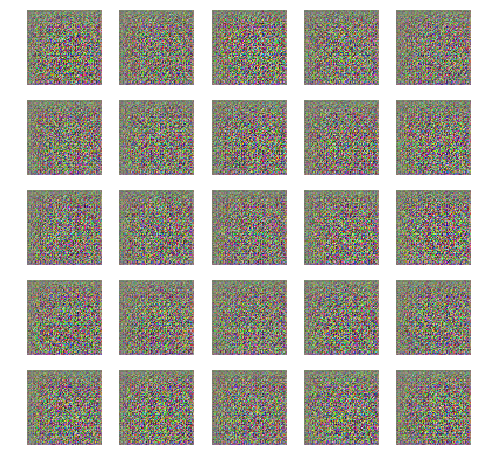

10 [Discriminator loss: 0.123577, acc.: 98.44%] [Generator loss: 1.955076]
20 [Discriminator loss: 0.175445, acc.: 93.75%] [Generator loss: 0.402028]
30 [Discriminator loss: 0.391471, acc.: 83.59%] [Generator loss: 4.322347]
40 [Discriminator loss: 0.030069, acc.: 100.00%] [Generator loss: 0.020160]
50 [Discriminator loss: 0.523248, acc.: 67.97%] [Generator loss: 5.585903]
60 [Discriminator loss: 0.466123, acc.: 79.69%] [Generator loss: 3.480604]
70 [Discriminator loss: 0.051952, acc.: 99.22%] [Generator loss: 0.061935]
80 [Discriminator loss: 0.109340, acc.: 98.44%] [Generator loss: 3.091930]
90 [Discriminator loss: 0.453349, acc.: 82.81%] [Generator loss: 6.475370]
100 [Discriminator loss: 0.271035, acc.: 90.62%] [Generator loss: 3.823373]
110 [Discriminator loss: 0.504101, acc.: 82.03%] [Generator loss: 3.311879]
120 [Discriminator loss: 0.297269, acc.: 90.62%] [Generator loss: 3.286774]
130 [Discriminator loss: 0.881703, acc.: 49.22%] [Generator loss: 4.995684]
140 [Discriminator l

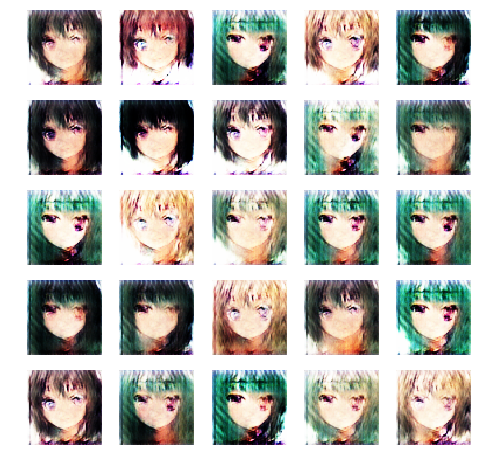

1210 [Discriminator loss: 0.060830, acc.: 100.00%] [Generator loss: 0.981045]
1220 [Discriminator loss: 0.280745, acc.: 90.62%] [Generator loss: 3.284468]
1230 [Discriminator loss: 0.423712, acc.: 82.03%] [Generator loss: 2.443418]
1240 [Discriminator loss: 0.360344, acc.: 82.81%] [Generator loss: 4.831253]
1250 [Discriminator loss: 0.211200, acc.: 96.09%] [Generator loss: 3.106979]
1260 [Discriminator loss: 0.688467, acc.: 67.97%] [Generator loss: 2.859139]
1270 [Discriminator loss: 0.077779, acc.: 98.44%] [Generator loss: 2.947799]
1280 [Discriminator loss: 0.344868, acc.: 81.25%] [Generator loss: 3.302160]
1290 [Discriminator loss: 0.985110, acc.: 65.62%] [Generator loss: 2.803746]
1300 [Discriminator loss: 0.638334, acc.: 73.44%] [Generator loss: 3.232905]
1310 [Discriminator loss: 0.269748, acc.: 89.06%] [Generator loss: 1.817045]
1320 [Discriminator loss: 0.354624, acc.: 87.50%] [Generator loss: 2.487347]
1330 [Discriminator loss: 0.181102, acc.: 95.31%] [Generator loss: 5.024367

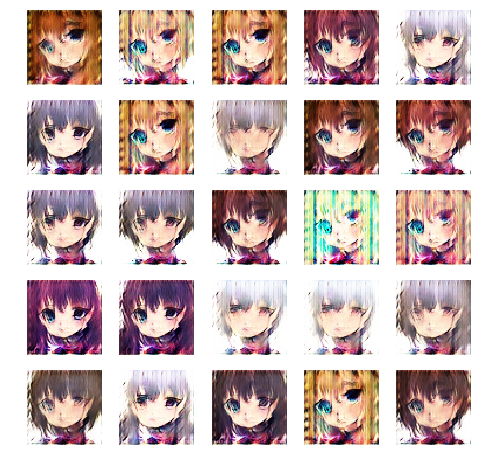

2410 [Discriminator loss: 0.369730, acc.: 82.81%] [Generator loss: 7.234772]
2420 [Discriminator loss: 0.019031, acc.: 100.00%] [Generator loss: 0.495272]
2430 [Discriminator loss: 0.099517, acc.: 98.44%] [Generator loss: 1.543725]
2440 [Discriminator loss: 0.106569, acc.: 96.88%] [Generator loss: 1.917642]
2450 [Discriminator loss: 0.207497, acc.: 90.62%] [Generator loss: 7.315956]
2460 [Discriminator loss: 0.138902, acc.: 93.75%] [Generator loss: 1.171691]
2470 [Discriminator loss: 0.094604, acc.: 97.66%] [Generator loss: 4.057129]
2480 [Discriminator loss: 0.305958, acc.: 86.72%] [Generator loss: 3.766420]
2490 [Discriminator loss: 0.185619, acc.: 94.53%] [Generator loss: 1.665926]
2500 [Discriminator loss: 0.231585, acc.: 90.62%] [Generator loss: 5.914989]
2510 [Discriminator loss: 0.069515, acc.: 98.44%] [Generator loss: 4.797246]
2520 [Discriminator loss: 0.124654, acc.: 95.31%] [Generator loss: 6.317520]
2530 [Discriminator loss: 0.068518, acc.: 96.88%] [Generator loss: 1.081743

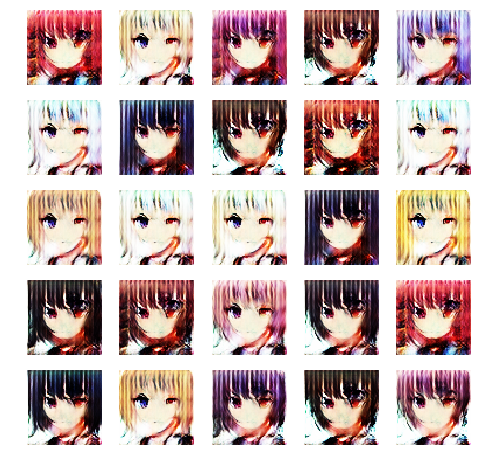

3610 [Discriminator loss: 0.198663, acc.: 91.41%] [Generator loss: 7.191004]
3620 [Discriminator loss: 0.079109, acc.: 95.31%] [Generator loss: 5.284478]
3630 [Discriminator loss: 0.140470, acc.: 94.53%] [Generator loss: 5.412089]
3640 [Discriminator loss: 0.099929, acc.: 98.44%] [Generator loss: 4.298120]
3650 [Discriminator loss: 0.180781, acc.: 92.19%] [Generator loss: 3.938048]
3660 [Discriminator loss: 0.126860, acc.: 96.09%] [Generator loss: 3.653069]
3670 [Discriminator loss: 0.140940, acc.: 95.31%] [Generator loss: 3.621831]
3680 [Discriminator loss: 0.095508, acc.: 97.66%] [Generator loss: 4.000477]
3690 [Discriminator loss: 0.111368, acc.: 97.66%] [Generator loss: 4.333307]
3700 [Discriminator loss: 0.302711, acc.: 88.28%] [Generator loss: 5.436240]
3710 [Discriminator loss: 0.117025, acc.: 96.09%] [Generator loss: 4.864909]
3720 [Discriminator loss: 0.075465, acc.: 97.66%] [Generator loss: 4.884544]
3730 [Discriminator loss: 0.142899, acc.: 92.97%] [Generator loss: 0.933772]

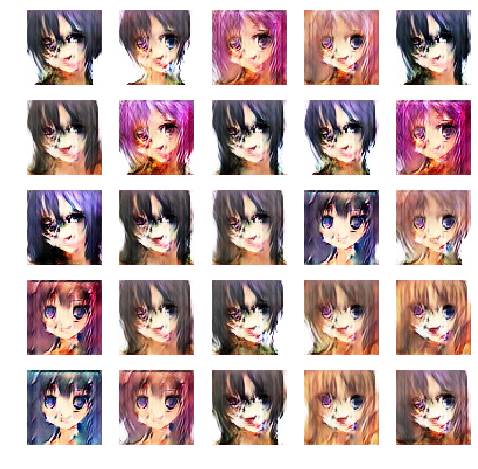

4810 [Discriminator loss: 0.045102, acc.: 97.66%] [Generator loss: 2.101715]
4820 [Discriminator loss: 0.334532, acc.: 85.94%] [Generator loss: 2.134628]
4830 [Discriminator loss: 0.122251, acc.: 95.31%] [Generator loss: 5.057166]
4840 [Discriminator loss: 0.174615, acc.: 93.75%] [Generator loss: 3.648840]
4850 [Discriminator loss: 0.240010, acc.: 90.62%] [Generator loss: 5.596762]
4860 [Discriminator loss: 0.069896, acc.: 98.44%] [Generator loss: 2.942087]
4870 [Discriminator loss: 0.174609, acc.: 92.97%] [Generator loss: 4.562685]
4880 [Discriminator loss: 0.383624, acc.: 84.38%] [Generator loss: 3.463570]
4890 [Discriminator loss: 0.098621, acc.: 96.09%] [Generator loss: 1.439739]
4900 [Discriminator loss: 0.182575, acc.: 94.53%] [Generator loss: 5.450293]
4910 [Discriminator loss: 0.119361, acc.: 95.31%] [Generator loss: 6.373105]
4920 [Discriminator loss: 0.051553, acc.: 99.22%] [Generator loss: 3.589113]
4930 [Discriminator loss: 0.062604, acc.: 98.44%] [Generator loss: 2.956025]

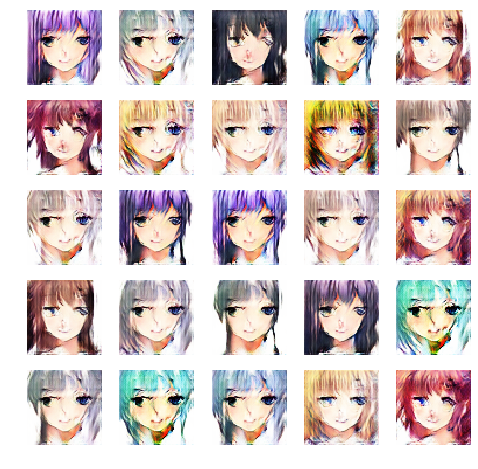

6010 [Discriminator loss: 0.084799, acc.: 98.44%] [Generator loss: 3.865786]
6020 [Discriminator loss: 0.108697, acc.: 96.88%] [Generator loss: 4.361135]
6030 [Discriminator loss: 0.049501, acc.: 99.22%] [Generator loss: 4.099487]
6040 [Discriminator loss: 0.527164, acc.: 77.34%] [Generator loss: 8.796268]
6050 [Discriminator loss: 0.140536, acc.: 95.31%] [Generator loss: 5.733111]
6060 [Discriminator loss: 0.378279, acc.: 82.81%] [Generator loss: 3.366207]
6070 [Discriminator loss: 0.094265, acc.: 96.88%] [Generator loss: 3.992502]
6080 [Discriminator loss: 0.187496, acc.: 92.19%] [Generator loss: 4.787431]
6090 [Discriminator loss: 0.148564, acc.: 92.97%] [Generator loss: 4.242078]
6100 [Discriminator loss: 0.131701, acc.: 95.31%] [Generator loss: 4.546709]
6110 [Discriminator loss: 0.118140, acc.: 96.88%] [Generator loss: 3.491547]
6120 [Discriminator loss: 0.172599, acc.: 93.75%] [Generator loss: 7.303967]
6130 [Discriminator loss: 0.375256, acc.: 84.38%] [Generator loss: 2.352967]

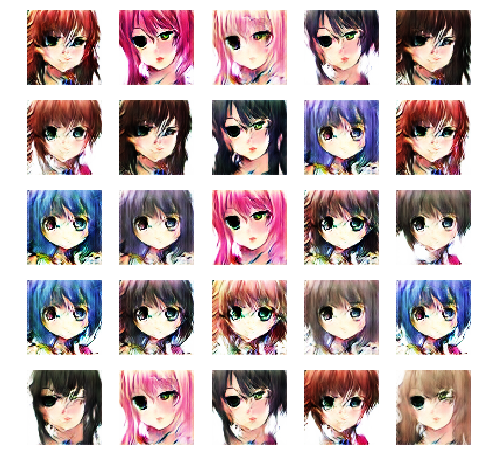

7210 [Discriminator loss: 0.112245, acc.: 95.31%] [Generator loss: 3.263882]
7220 [Discriminator loss: 0.085119, acc.: 96.88%] [Generator loss: 4.707985]
7230 [Discriminator loss: 0.095651, acc.: 96.88%] [Generator loss: 5.184836]
7240 [Discriminator loss: 0.068430, acc.: 98.44%] [Generator loss: 4.366097]
7250 [Discriminator loss: 0.140932, acc.: 94.53%] [Generator loss: 5.514445]
7260 [Discriminator loss: 0.344059, acc.: 82.81%] [Generator loss: 6.088622]
7270 [Discriminator loss: 0.099145, acc.: 96.09%] [Generator loss: 4.070220]
7280 [Discriminator loss: 0.432695, acc.: 83.59%] [Generator loss: 5.023960]
7290 [Discriminator loss: 0.069174, acc.: 97.66%] [Generator loss: 4.470170]
7300 [Discriminator loss: 0.115617, acc.: 95.31%] [Generator loss: 5.151694]
7310 [Discriminator loss: 0.114503, acc.: 96.09%] [Generator loss: 5.627014]
7320 [Discriminator loss: 0.134442, acc.: 95.31%] [Generator loss: 6.319558]
7330 [Discriminator loss: 0.184346, acc.: 91.41%] [Generator loss: 5.502625]

In [0]:
gan=GAN()
gan.train(epochs=30001, batch_size=128, save_interval=300)